In [1]:
import pydicom
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import re
import math

## Data statistics for SIIM datset

In [2]:
data_dir = "~/var/aml-xrays/"
save_dir = "../imgs/stats/siim/"

In [3]:
data_path = Path(data_dir).expanduser()

In [4]:
image_level = pd.read_csv(data_path / "train_image_level.csv")
study_level = pd.read_csv(data_path / "train_study_level.csv")

## Data Statistics for all data

In [19]:
image_level.count()

id                  6334
boxes               4294
label               6334
StudyInstanceUID    6334
dtype: int64

In [20]:
study_level.count()

id                          6054
Negative for Pneumonia      6054
Typical Appearance          6054
Indeterminate Appearance    6054
Atypical Appearance         6054
dtype: int64

## Data statistics for image level

In [21]:
image_level

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [19]:
labels = image_level["label"]
opacity_count, none_count = 0,0 

for label in labels:
    if "opacity" in label:
        opacity_count +=1
    if "none" in label:
        none_count +=1
        
opacity_count + none_count

6334

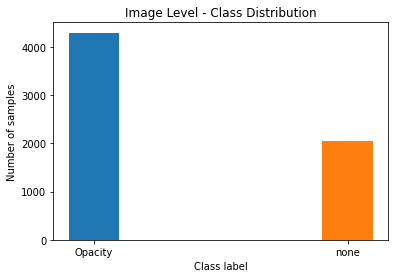

In [20]:
fig, ax = plt.subplots()
plt.title("Image Level - Class Distribution")
plt.ylabel("Number of samples")
plt.xlabel("Class label")
ax.bar("Opacity",opacity_count, width=.2)
ax.bar("none", none_count, width=.2)
fig.savefig(save_dir + "class_distribution_image.png",dpi=100)

In [21]:
boxes = image_level["boxes"]
dist = {}
for box in boxes:
    try:
        box_cnt = len(ast.literal_eval(box))
        if box_cnt in dist:
                dist[box_cnt] += 1
        else:
            dist[box_cnt] = 1
    except:
        if "NaN" in dist:
            dist["NaN"] += 1
        else:
            dist["NaN"] =1
dist

{2: 3113, 'NaN': 2040, 1: 973, 3: 183, 4: 23, 5: 1, 8: 1}

In [22]:
sum(dist.values())

6334

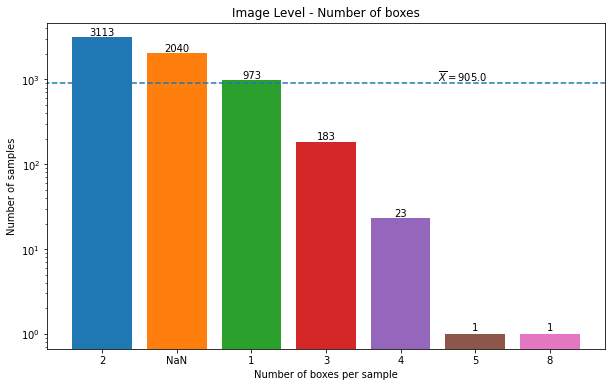

In [30]:
avg = round(sum(dist.values())/len(dist.keys()),0)
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Image Level - Number of boxes")
plt.ylabel("Number of samples")
plt.xlabel("Number of boxes per sample")
ax.set_yscale('log')
ax.hlines(round(avg,1), -1,50, linestyle="dashed")
ax.annotate("$\overline{X}=$"+f"{avg}",(4.5,avg+50))
for i,key in enumerate(dist.keys()):
    ax.bar(str(key),dist[key])
for i, patch in enumerate(ax.patches):
    ax.text(
        patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.05, list(dist.values())[i], ha="center", va="bottom"
    )
fig.savefig(save_dir + "box_distribution_image.png",dpi=100)


In [14]:
from tqdm import tqdm

def resolve_image_paths(study_id, dataset="train"):
    study_path = data_path / dataset / study_id
    image_paths = []
    for series_path in study_path.iterdir():
        if series_path.is_dir():
            [image_paths.append(image_path) for image_path in series_path.iterdir()]
    return image_paths

def study_id_from_csv_id(csv_id):
    return csv_id[:-6]

def csv_id_to_paths(csv_id, dataset="train"):
    return resolve_image_paths(study_id_from_csv_id(csv_id), dataset)

def add_and_count(attr, attr_dict, dcm):
    value = None
    if attr in dcm:
        value = dcm[attr].value
    if attr in dcm.file_meta:
        value = dcm.file_meta[attr].value
    if value is not None:
        attr_dict[attr][value] = attr_dict[attr].get(value, 0) + 1

def find_attribute_values_and_count(dicom_attrs: list[str]):
    attr_dict = {}
    for attr in dicom_attrs:
        attr_dict[attr] = dict()

    for study in tqdm(study_level['id']):
        paths = csv_id_to_paths(study)
        for single_path in paths:
            dcm = pydicom.dcmread(single_path)
            for attr in attr_dict.keys():
                add_and_count(attr, attr_dict, dcm)

    return attr_dict

def studies_for_attr(tag):
    attr_dict = {}
    for study in tqdm(study_level['id']):
        paths = csv_id_to_paths(study)
        for single_path in paths:
            dcm = pydicom.dcmread(single_path)
            value = None
            if tag in dcm:
                value = dcm[tag].value
            if tag in dcm.file_meta:
                value = dcm.file_meta[tag].value
            if value is not None:
                attr_list = attr_dict.get(value, [])
                attr_list.append(dcm.StudyInstanceUID)
                attr_dict[value] = attr_list
    return attr_dict

In [12]:
find_attribute_values_and_count(['PatientSex', 'PatientAge', 'PhotometricInterpretation', 'BitsAllocated', 'BitsStored', 'Modality', 'TransferSyntaxUID', 'BodyPartExamined'])

100%|██████████| 6054/6054 [01:35<00:00, 63.37it/s] 


{'PatientSex': {'F': 2770, 'M': 3564},
 'PatientAge': {},
 'PhotometricInterpretation': {'MONOCHROME2': 4633, 'MONOCHROME1': 1701},
 'BitsAllocated': {16: 5933, 8: 401},
 'BitsStored': {12: 4311, 15: 1240, 14: 210, 8: 401, 16: 166, 10: 3, 13: 3},
 'Modality': {'DX': 3242, 'CR': 3092},
 'TransferSyntaxUID': {'1.2.840.10008.1.2.1': 5894,
  '1.2.840.10008.1.2.4.70': 440},
 'BodyPartExamined': {'CHEST': 5050,
  'TORAX': 307,
  '': 381,
  '2- TORAX': 7,
  'PORT CHEST': 249,
  'THORAX': 77,
  'TÒRAX': 5,
  'ABDOMEN': 21,
  'T?RAX': 156,
  'SKULL': 57,
  'PECHO': 3,
  'Pecho': 21}}

In [16]:
body_parts = studies_for_attr("BodyPartExamined")


100%|██████████| 6054/6054 [01:37<00:00, 61.81it/s] 


## Average box size

In [72]:
box_size = 0
box_count = 0
box_sizes = []
for box in boxes:
    try:
        for img_box in ast.literal_eval(box):
            box_count += 1
            box_size += (img_box["width"] * img_box["height"])
            box_sizes.append(math.ceil((img_box["width"] * img_box["height"])))
    except:
        pass
    
print(f'Average box has a size of {round(box_size/box_count,2)} px')

Average box has a size of 824588.02 px


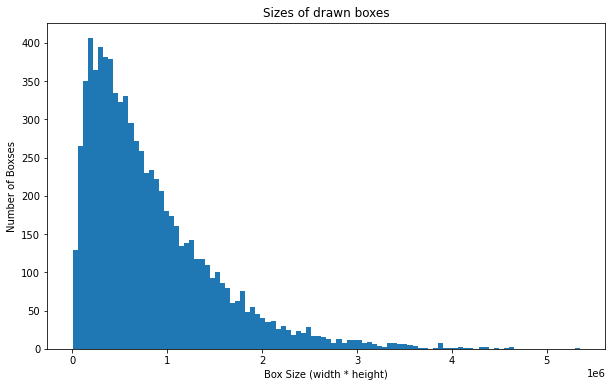

In [87]:
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(box_sizes, density=False, bins=100)
plt.title("Sizes of drawn boxes")
plt.ylabel('Number of Boxses')
plt.xlabel('Box Size (width * height)')
fig.savefig(save_dir + "box_size_distribution.png",dpi=80)
plt.show()

## How many images per study ?

In [17]:
study_groups = image_level.groupby("StudyInstanceUID").size()
print(study_groups)

StudyInstanceUID
00086460a852    1
000c9c05fd14    1
00292f8c37bd    1
005057b3f880    1
0051d9b12e72    1
               ..
ffcb4630f46f    2
ffe4d6e8fbb0    1
ffe94fcb14fa    1
ffebf1ef4a9c    1
fff649d65f62    1
Length: 6054, dtype: int64


In [61]:
print(f'There are {len(image_level.index)/len(study_groups.index)} images per study')

There are 1.0462504129501156 images per study


## Data statistics for each study level

In [14]:
study_level

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [33]:
sums = study_level.drop(["id"], axis=1).sum()

In [89]:
sums

Negative for Pneumonia      1676
Typical Appearance          2855
Indeterminate Appearance    1049
Atypical Appearance          474
dtype: int64

In [34]:
typ_app = sums["Typical Appearance"]
ind_app = sums["Indeterminate Appearance"]
atyp_app = sums["Atypical Appearance"]
neg_pn = sums["Negative for Pneumonia"]
count_list = [typ_app, ind_app, atyp_app, neg_pn]
avg = (neg_pn + ind_app + typ_app + atyp_app) / 4
avg

1513.5

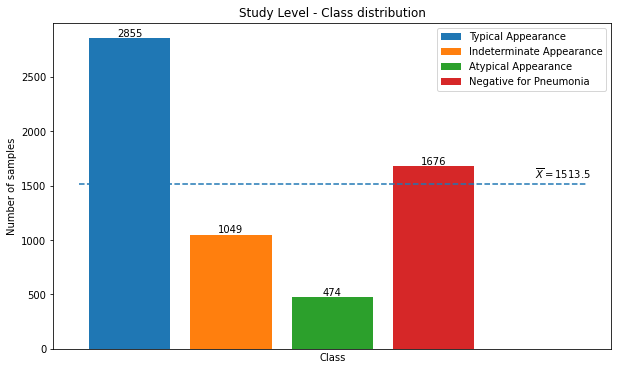

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Study Level - Class distribution")
plt.ylabel("Number of samples")
plt.xlabel("Class")
ax.bar(0,typ_app)
ax.bar(1,ind_app)
ax.bar(2,atyp_app)
ax.bar(3,neg_pn)
ax.set_xticks([])
ax.legend(labels=["Typical Appearance","Indeterminate Appearance","Atypical Appearance","Negative for Pneumonia"])
ax.hlines(avg,-.5,4.5,linestyle="dashed")
ax.annotate("$\overline{X}=$"+f"{avg}",(4,avg+50))
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.05, count_list[i], ha="center", va="bottom")
fig.savefig(save_dir + "class_distrinution_study.png",dpi=100)

## Sample Submission Data

In [6]:
sample_sub = pd.read_csv(data_path / "sample_submission.csv")
sample_sub

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


In [9]:
pred_strings = sample_sub["PredictionString"]

## Data Statistics for NIH (pretraining backbones)

In [1]:
data_dir = "../data/NIH/Data_Entry_2017.csv"
save_dir = "../imgs/stats/chest14/"
nih_classes = [
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Effusion',
    'Emphysema',
    'Fibrosis',
    'Hernia',
    'Infiltration',
    'Mass',
    'No Finding',
    'Nodule',
    'Pleural_Thickening',
    'Pneumonia',
    'Pneumothorax',
]

In [4]:
nih = pd.read_csv(data_dir)

In [5]:
nih.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
label_list =  []
for label in nih["Finding Labels"]:
    for split in label.split("|"):
        label_list.append(split)

In [7]:
print(f'each patien has an average of {len(label_list)/len(nih)} findings')

each patien has an average of 1.2623706742775598 findings


In [13]:
count_per_label = pd.DataFrame(data=np.array(label_list),columns=['findings']).groupby("findings").size()
avg = round(len(label_list)/len(nih_classes))

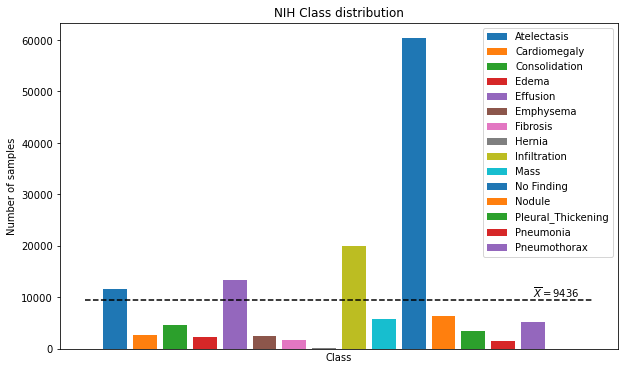

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("NIH Class distribution")
plt.ylabel("Number of samples")
plt.xlabel("Class")
for i,cl in enumerate(nih_classes):
    ax.bar(i,count_per_label[cl])
ax.set_xticks([])
ax.legend(labels=nih_classes)
ax.hlines(avg,-1,16,linestyle="dashed")
ax.annotate("$\overline{X}=$"+f"{avg}",(14,avg+500))
fig.savefig(save_dir + "class_distrinution.png",dpi=100)

## Data Statistics for RSNA dataset (Pretraining YOLO)

In [6]:
data_dir = "../data/RSNA/stage_2_detailed_class_info.csv"

save_dir = "../imgs/stats/RSNA/"

In [9]:
rsna = pd.read_csv(data_dir)
train_labels = pd.read_csv("../data/RSNA/stage_2_train_labels.csv")

In [8]:
rsna.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [13]:
len(rsna)

30227

In [18]:
type(train_labels)

pandas.core.frame.DataFrame

In [20]:
train_labels.groupby("Target").size()

Target
0    20672
1     9555
dtype: int64